# Logistic Regression Illustrated with Tensorflow

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2023-01-31 10:18:32.849593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data for Modeling
Below, we'll train models on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This dataset consists of 70,000 grayscale 28x28 images. Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

### Step 1: Load the Data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Flatten Y_train and Y_test so they become vectors of label values
# Note: The label for X_train[0] is in Y_train[0]
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

### Step 2: Basic EDA
`X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. We'll print their shapes to confirm.

In [3]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
Y_test.shape: (10000,)


There are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel). Before we continue, we'll apply linear scaling to our pixel values so they all fall between 0 and 1.

In [4]:
# Pixel values range from 0 to 255 - to normalize the data, we need to divide all values by 255
X_train = X_train / 255
X_test = X_test / 255

We'll treat **every pixel value as a separate feature** so each input example has 28x28 (784) features. Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, we'll keep a list of (string) names for convenience.

In [5]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

Now we'll use the `imshow` function to look at the first few images in the training set.

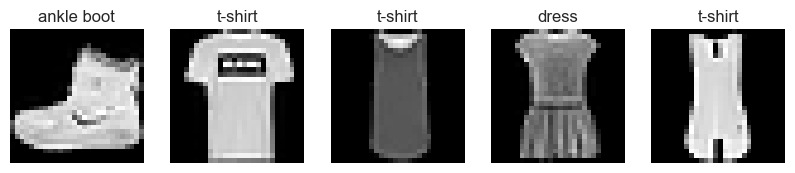

In [6]:
# Create a figure showing the first five images in the training set
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
    image = X_train[i]
    label = Y_train[i]
    label_name = label_names[label]
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(label_name)
    axs[i].axis('off')
plt.show()

Now, we'll display the **first 5 images for each class** in a 10x5 grid.

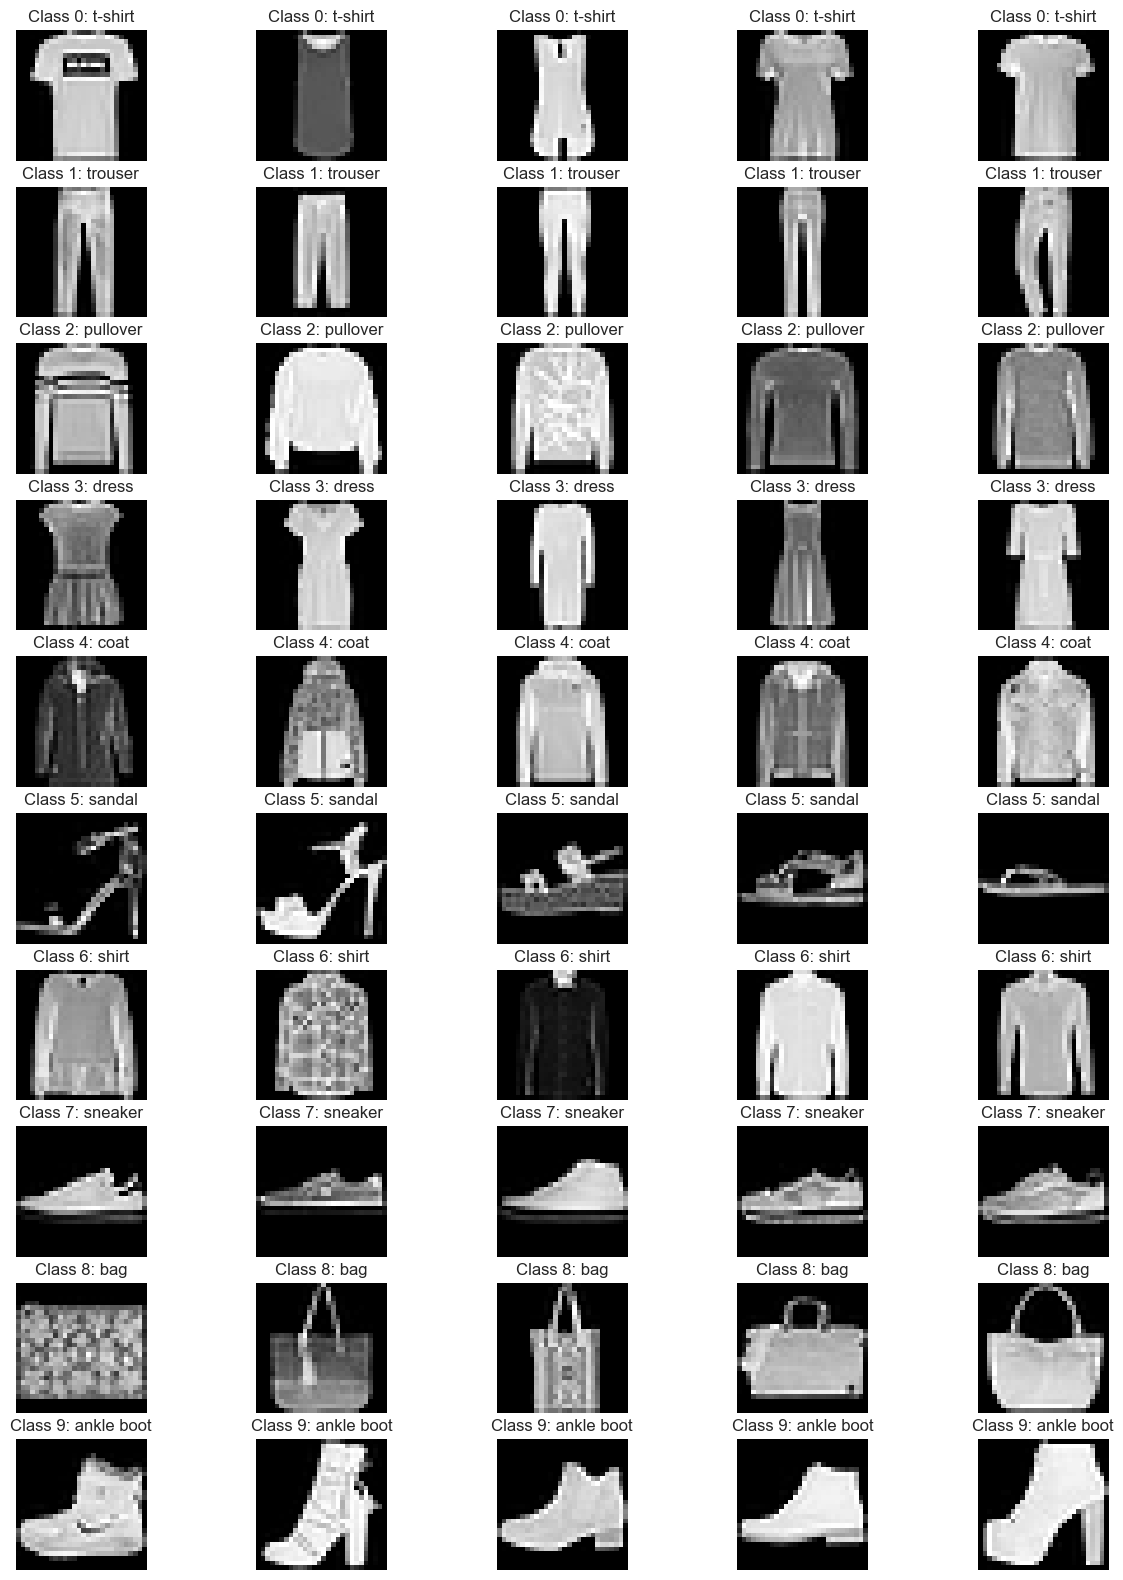

In [7]:
# Create a 10x5 grid to hold all the images
fig, axes = plt.subplots(10, 5, figsize = (15, 20))
axes = axes.reshape(-1)

# Iterate over the 10 classes, find the indices of the first 5 images of each class, and plot them
for i in range(10):
    image_indices = np.where(Y_train == i)[0][:5]
    label = label_names[i]
    for j, image_index in enumerate(image_indices):
        axes[i * 5 + j].imshow(X_train[image_index], cmap = "gray")
        axes[i * 5 + j].set_title(f"Class {i}: {label}", loc = "center")
        axes[i * 5 + j].axis("off")
plt.show()

## Sneaker Classification
There are many things we can do with this dataset. We'll start with binary classification and train a sneaker classifier using sneaker images (class 7) as our positive examples ($y=1$) and all other images as negative examples ($y=0$).

After we've trained a model, it will produce predictions $\hat{y}$ (in this case, the probability that an input image $x$ is a sneaker).

### Step 3: Data Preprocessing
Before continuing, we'll need to prepare the data for our binary classification task. The label for all the sneaker images should be 1 and the label for all the non-sneaker images should be 0.

In [8]:
# Make copies of the original dataset for binary classification task
X_train_binary = np.copy(X_train)
X_test_binary = np.copy(X_test)
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Set labels: 1 for sneaker images, 0 for the others
# Note: A boolean array is created when Y_train_binary != 7 is evaluated
Y_train_binary[Y_train_binary != 7] = 0.0 
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0

Before training any models, we'll work a bit more with our raw feature values, comparing sneaker and non-sneaker images.

We'll proceed with the following four steps:
1. Find all sneaker images in `X_train_binary` and compute the mean and standard deviation of the center pixel across all sneaker images. The center pixel is located at position [14, 14].

2. Find all non-sneaker images in `X_train_binary` and compute the mean and standard deviation of the center pixel across all non-sneaker images. The center pixel is located at position [14, 14].

3. Repeat 1 and 2 for the pixel located at positon [3, 14].

4. Based on these results, evaluate whether there is some evidence that suggests we can use pixel values to discriminate between sneaker and non-sneaker images.

In [9]:
## Part 1: Compute mean and std for center pixel across all sneaker images (X_train_binary)
#################################################################################################################

# Restrict X_train_binary to just sneaker images (Class = 7) and define center pixel position
sneaker_indices = np.where(Y_train == 7)[0]
center_pixel_sneaker = X_train_binary[sneaker_indices, 14:15, 14:15].flatten()

# Perform mean and std calculations (and provide image count for context)
center_pixel_sneaker_mean = round(np.mean(center_pixel_sneaker), 10)
center_pixel_sneaker_std = round(np.std(center_pixel_sneaker), 10)
center_pixel_sneaker_count = len(center_pixel_sneaker)

# Display mean and std calculations
print("Part 1: Compute mean and std for center pixel across all sneaker images in X_train_binary")
print("....................................................................................................\n")
print(f"Mean [center pixel, sneaker images]: {center_pixel_sneaker_mean}")
print(f"Standard Deviation [center pixel, sneaker images]: {center_pixel_sneaker_std}")
print(f"Image Count [sneaker images]: {center_pixel_sneaker_count}")

print("\n====================================================================================================\n")

## Part 2: Compute mean and std for center pixel across all non-sneaker images (X_train_binary)
#################################################################################################################

# Restrict X_train_binary to just non-sneaker images (Class != 7) and define center pixel position
nonsneaker_indices = np.where(Y_train != 7)[0]
center_pixel_nonsneaker = X_train_binary[nonsneaker_indices, 14:15, 14:15].flatten()

# Perform mean and std calculations (and provide image count for context)
center_pixel_nonsneaker_mean = round(np.mean(center_pixel_nonsneaker), 10)
center_pixel_nonsneaker_std = round(np.std(center_pixel_nonsneaker), 10)
center_pixel_nonsneaker_count = len(center_pixel_nonsneaker)

# Display mean and std calculations
print("Part 2: Compute mean and std for center pixel across all non-sneaker images in X_train_binary")
print("....................................................................................................\n")
print(f"Mean [center pixel, non-sneaker images]: {center_pixel_nonsneaker_mean}")
print(f"Standard Deviation [center pixel, non-sneaker images]: {center_pixel_nonsneaker_std}")
print(f"Image Count [non-sneaker images]: {center_pixel_nonsneaker_count}")

print("\n====================================================================================================\n")

## Part 3: Compute mean and std for non-center pixel across all sneaker/non-sneaker images (X_train_binary)
#################################################################################################################

# Restrict X_train_binary to just sneaker images (Class = 7) and define non-center pixel position
noncenter_pixel_sneaker = X_train_binary[sneaker_indices, 3:4, 14:15].flatten()

# Restrict X_train_binary to just non-sneaker images (Class != 7) and define non-center pixel position
noncenter_pixel_nonsneaker = X_train_binary[nonsneaker_indices, 3:4, 14:15].flatten()

# Perform mean and std calculations (and provide image count for context)
noncenter_pixel_sneaker_mean = round(np.mean(noncenter_pixel_sneaker), 10)
noncenter_pixel_sneaker_std = round(np.std(noncenter_pixel_sneaker), 10)
noncenter_pixel_sneaker_count = len(noncenter_pixel_sneaker)
noncenter_pixel_nonsneaker_mean = round(np.mean(noncenter_pixel_nonsneaker), 10)
noncenter_pixel_nonsneaker_std = round(np.std(noncenter_pixel_nonsneaker), 10)
noncenter_pixel_nonsneaker_count = len(noncenter_pixel_nonsneaker)

# Display mean and std calculations
print("Part 3: Compute mean and std for non-center pixel across all sneaker/non-sneaker images in X_train_binary")
print("....................................................................................................\n")
print(f"Mean [non-center pixel, sneaker images]: {noncenter_pixel_sneaker_mean}")
print(f"Standard Deviation [non-center pixel, sneaker images]: {noncenter_pixel_sneaker_std}")
print(f"Image Count [sneaker images]: {noncenter_pixel_sneaker_count}")
print("---")
print(f"Mean [non-center pixel, non-sneaker images]: {noncenter_pixel_nonsneaker_mean}")
print(f"Standard Deviation [non-center pixel, non-sneaker images]: {noncenter_pixel_nonsneaker_std}")
print(f"Image Count [non-sneaker images]: {noncenter_pixel_nonsneaker_count}")

Part 1: Compute mean and std for center pixel across all sneaker images in X_train_binary
....................................................................................................

Mean [center pixel, sneaker images]: 0.6279993464
Standard Deviation [center pixel, sneaker images]: 0.2420192071
Image Count [sneaker images]: 6000


Part 2: Compute mean and std for center pixel across all non-sneaker images in X_train_binary
....................................................................................................

Mean [center pixel, non-sneaker images]: 0.5365848221
Standard Deviation [center pixel, non-sneaker images]: 0.3148974734
Image Count [non-sneaker images]: 54000


Part 3: Compute mean and std for non-center pixel across all sneaker/non-sneaker images in X_train_binary
....................................................................................................

Mean [non-center pixel, sneaker images]: 0.0012503268
Standard Deviation [non-center pixe

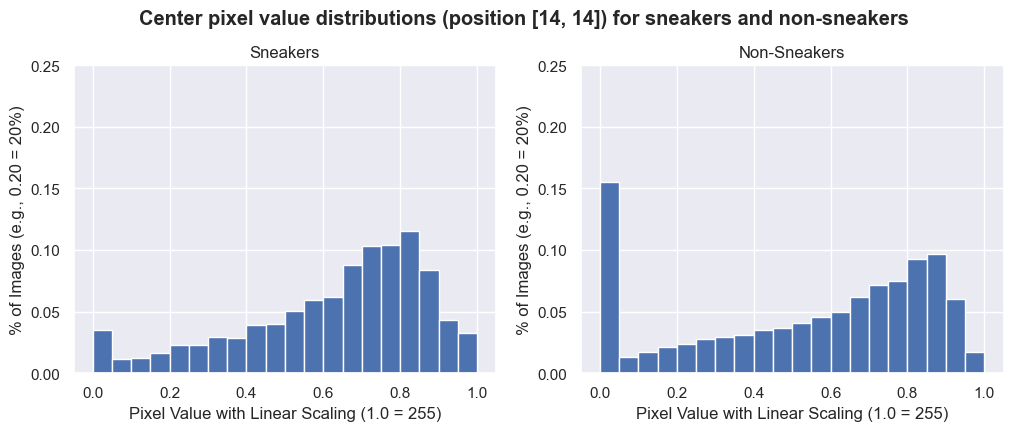

In [10]:
# Define figure to plot histograms of sneaker and non-sneaker center pixel value distributions
plt.figure(1, figsize = (12, 4))
plt.suptitle("Center pixel value distributions (position [14, 14]) for sneakers and non-sneakers",
             fontweight = "bold",
             y = 1.02)

# Histogram subplot 1 - sneakers
plt.subplot(121)
plt.title("Sneakers")
plt.xlabel("Pixel Value with Linear Scaling (1.0 = 255)")
plt.ylabel("% of Images (e.g., 0.20 = 20%)")
plt.ylim(0, 0.25)
plt.hist(center_pixel_sneaker,
         bins = 20,
         weights = np.ones_like(center_pixel_sneaker) / len(center_pixel_sneaker))

# Histogram subplot 2 - non-sneakers
plt.subplot(122)
plt.title("Non-Sneakers")
plt.xlabel("Pixel Value with Linear Scaling (1.0 = 255)")
plt.ylabel("% of Images (e.g., 0.20 = 20%)")
plt.ylim(0, 0.25)
plt.hist(center_pixel_nonsneaker,
         bins = 20,
         weights = np.ones_like(center_pixel_nonsneaker) / len(center_pixel_nonsneaker))

# Show histogram subplots
plt.show()

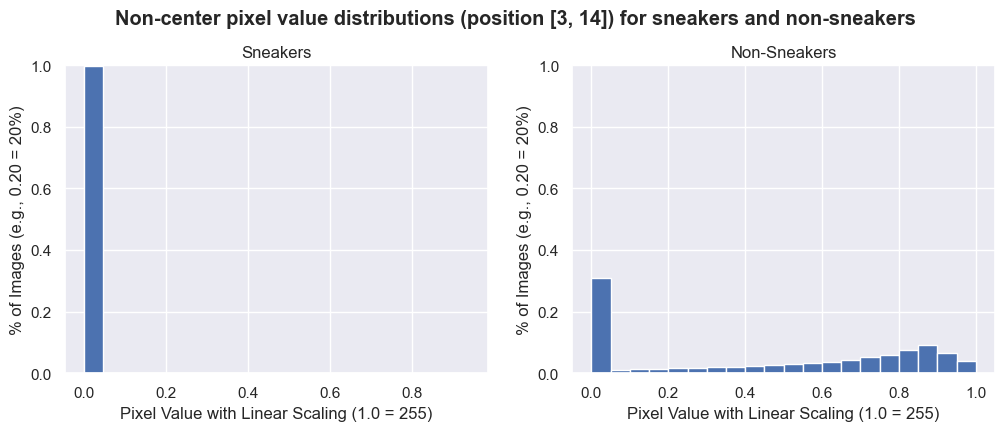

In [11]:
# Define figure to plot histograms of sneaker and non-sneaker non-center pixel value distributions
plt.figure(2, figsize = (12, 4))
plt.suptitle("Non-center pixel value distributions (position [3, 14]) for sneakers and non-sneakers",
             fontweight = "bold",
             y = 1.02)

# Histogram subplot 1 - sneakers
plt.subplot(121)
plt.title("Sneakers")
plt.xlabel("Pixel Value with Linear Scaling (1.0 = 255)")
plt.ylabel("% of Images (e.g., 0.20 = 20%)")
plt.ylim(0, 1)
plt.hist(noncenter_pixel_sneaker,
         bins = 20,
         weights = np.ones_like(noncenter_pixel_sneaker) / len(noncenter_pixel_sneaker))

# Histogram subplot 2 - non-sneakers
plt.subplot(122)
plt.title("Non-Sneakers")
plt.xlabel("Pixel Value with Linear Scaling (1.0 = 255)")
plt.ylabel("% of Images (e.g., 0.20 = 20%)")
plt.ylim(0, 1)
plt.hist(noncenter_pixel_nonsneaker,
         bins = 20,
         weights = np.ones_like(noncenter_pixel_nonsneaker) / len(noncenter_pixel_nonsneaker))

# Show histogram subplots
plt.show()

*Reflections:*

1. **Mean and Standard Deviation Values for Center Pixel (position [14, 14]) Across all Sneaker Images**

Measure | Value
:--- | :---
Mean | 0.6279993464
Standard Deviation | 0.2420192071


2. **Mean and Standard Deviation Values for Center Pixel (position [14, 14]) Across all Non-Sneaker Images**

Measure | Value
:--- | :---
Mean | 0.5365848221
Standard Deviation | 0.3148974734


3. **Mean and Standard Deviation Values for Non-Center Pixel (position [3, 14]) Across all Sneaker and Non-Sneaker Images**

Measure | Value
:--- | :---
Mean [Sneaker Images] | 0.0012503268
Standard Deviation [Sneaker Images] | 0.0282934709
 | 
Mean [Non-Sneaker Images] | 0.4643728395
Standard Deviation [Non-Sneaker Images] | 0.3678363831


4. Based on these results, we *should* be able to use pixel values to discriminate between sneaker and non-sneaker images. Although the sneaker images and non-sneaker images have similar (or at least, presumably, not statistically different) mean and standard deviation values for their center pixel at position [14, 14], the sneaker images have a much smaller mean and standard deviation value for the pixel at position [3, 14] (a non-centered pixel) than the non-sneaker images. Histograms of pixel values across sneaker and non-sneaker images serve as helpful visualizations to further support this point. This means that we should be able to use a non-centered pixel to help us classify certain images as sneakers and other images as non-sneakers with at least a reasonable degree of accuracy. Practically, based on the mean and standard deviation values, this non-centered pixel should show up as much darker in the sneaker images (with the mean value across these images being small) than in the non-sneaker images, since sneaker images tend to be long width-wise but not tall height-wise in the image frame while most other images (with the exception of sandals, where we may see the highest rate of false positive attributions to sneakers) tend to be slim width-wise and tall height-wise or both long width-wise and tall height-wise in the image frame.

### Step 4: Data Shuffling
We'll use SGD (Stochastic Gradient Descent) for training. This means that it's important that **each batch is a random sample of the data**.

We'll use [integer array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing) to re-order the data and labels using a list of shuffled indices.

In [12]:
# Set random seed for reproducibility
np.random.seed(0)

indices = np.arange(X_train_binary.shape[0])
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly shuffled indices
X_train_binary = X_train_binary[shuffled_indices]
Y_train_binary = Y_train_binary[shuffled_indices]

## Logistic Regression

Logistic regression is an application of the logistic (sigmoid) function to the linear regression model:

\begin{equation}
y=\frac{1}{1+e^{-z}} 
\end{equation}

<center>
<img src="https://developers.google.com/machine-learning/crash-course/images/SigmoidFunction.png" alt="Sigmoid Function" width="45%"/>
</center>

where:

\begin{equation}
z = b + w_1x_1 + w_2x_2 + ... + w_nx_n
\end{equation}

The output $y$ is in the range $[0,1]$, the probability of the positive class. If we want a label (instead of a probability), we need to choose a threshold, like $0.5$. A value above or equal to that threshold indicates that the input should be classified as positive (e.g., sneaker); a value below the threshold indicates that the input should be classified as negative (e.g. non-sneaker).

## Log Loss (Binary Cross-Entropy) Function

In place of MSE –– which is used for linear regression –– logistic regression uses a loss function that's appropriate for classification. *Log Loss* (also known as *Binary Cross-Entropy*) is defined as follows:

\begin{equation}
-\frac{1}{|Y|} \sum_{y_i \in Y}y_i log(\hat{y}_i) + (1−y_i)log(1−\hat{y}_i)
\end{equation}

$y_i$ is the label for example $i$ and $\hat{y_i}$ is the predicted probability (of the positive class) for example $i$. Only the first term in the sum is active for positive examples (the second term is 0 when $y_i = 1$), and only the second term in the sum is active for negative examples (the first term is 0 when $y_i = 0$).

The Log Loss is differentiable, allowing us to compute gradients and run SGD. It also happens to be convex, which guarantees that SGD (with a suitable learning rate) will produce a global minimum.

### Step 5: Establish a Baseline

When dealing with classification problems, a simple but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%). So our majority class baseline would classify everything as *non-sneaker*. For our particular dataset, this should yield an accuracy of 90%. We'll see if we can train a model that beats the baseline.

In [13]:
print("Number of sneaker images in training set: %d"%(Y_train_binary == 1).sum())
print("Number of non-sneaker images in training set: %d"%(Y_train_binary == 0).sum())

Number of sneaker images in training set: 6000
Number of non-sneaker images in training set: 54000


Now we'll implement a function that computes the Log Loss metric and use it to evaluate our baseline on both the training and test data. We'll use 0.1 as the predicted probability for our baseline (reflecting what we know about the original distribution of classes in our dataset).

In [14]:
def log_loss(Y_true, Y_pred):
    """Returns the binary log loss for a list of labels and predictions.
  
    Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

    Returns:
    Binary log loss
    """
    binary_log_loss = round(-np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred)), 10)
    return binary_log_loss

# Implementing log_loss function on baseline model for training and test datasets
Y_true_train = Y_train_binary
Y_pred_train = 0.1
Y_true_test = Y_test_binary
Y_pred_test = 0.1

# Display log loss values for training and test datasets
print("Log loss on training dataset -- baseline model:", log_loss(Y_true_train, Y_pred_train))
print("Log loss on test dataset -- baseline model:", log_loss(Y_true_test, Y_pred_test))

Log loss on training dataset -- baseline model: 0.3250829734
Log loss on test dataset -- baseline model: 0.3250829734


### Step 6: Build a Model using Tensorflow
We'll use Tensorflow/Keras to build a logistic regression model:
* We'll use the Keras flatten layer to turn the 2-D 28x28 pixel grid inputs into 1-D vector inputs.
* We'll configure our dense layer with a sigmoid activation, which applies a sigmoid function to the output of the linear mapping $xW^T$.
* We'll specify binary_crossentropy as the loss when compiling the model.

In [15]:
def build_model(learning_rate=0.01):
    """Build a TF logistic regression model using Keras.

    Args:
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Clear extra copies of graph and set seed for results consistency
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Build a model using keras.Sequential
    model = keras.Sequential()

    # Keras layers can do pre-processing - this layer flatten 28x28 images into vectors of size 784
    model.add(keras.layers.Flatten())
  
    # This layer constructs the linear set of parameters for each input feature and applies a sigmoid
    model.add(keras.layers.Dense(
        units=1,                     # output dim (for binary classification)
        use_bias=True,               # use a bias param
        activation="sigmoid"         # apply the sigmoid function
    ))

    # Use mini-batch SGD for optimization
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model and specify loss function to finalize the graph for training
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.binary_accuracy])
    return model

We'll test the model building code to make sure it works. Before training, the parameters of the model are initialized randomly by default. While the untrained model won't make good predictions, we'll still be able to pass data through it and get probability outputs.

In [16]:
# Build the model
model = build_model()

# Make a prediction for five inputs
print(model.predict(X_train_binary[0:5]))

1/1 [==============================] - 0s 85ms/step
[[0.6295337]
 [0.5895071]
 [0.5546988]
 [0.5013851]
 [0.6702645]]


2023-01-31 10:18:44.132903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As expected, the outputs look like probabilities in [0,1]. Once the model is trained, we'll expect these predictions to correspond to the probability that each input image is a sneaker.

### Step 7: Train a Model
We'll now train a model. We'll use 10% of the training data as a *validation split*. This serves a similar purpose to our test data, allowing us to check for over-fitting during training. We don't use the test data here because we want to preserve the purity of this data for the cleanest possible evaluation at the end of the modeling process.

In [17]:
# Construct model for training
model = build_model(learning_rate=0.01)

# Fit the model
history = model.fit(
  x = X_train_binary,   # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # set aside fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the loss and binary accuracy after every epoch
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 1s 1ms/step - loss: 0.1412 - binary_accuracy: 0.9405 - val_loss: 0.1149 - val_binary_accuracy: 0.9502
Epoch 2/5
844/844 [==============================] - 1s 864us/step - loss: 0.1063 - binary_accuracy: 0.9562 - val_loss: 0.1029 - val_binary_accuracy: 0.9573
Epoch 3/5
844/844 [==============================] - 1s 877us/step - loss: 0.0962 - binary_accuracy: 0.9627 - val_loss: 0.0958 - val_binary_accuracy: 0.9605
Epoch 4/5
844/844 [==============================] - 1s 881us/step - loss: 0.0897 - binary_accuracy: 0.9664 - val_loss: 0.0908 - val_binary_accuracy: 0.9635
Epoch 5/5
844/844 [==============================] - 1s 856us/step - loss: 0.0851 - binary_accuracy: 0.9690 - val_loss: 0.0875 - val_binary_accuracy: 0.9645


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.141238,0.940463,0.114891,0.950167
1,0.106311,0.956167,0.102905,0.957333
2,0.096188,0.962704,0.095803,0.960500
3,0.089720,0.966389,0.090773,0.963500
4,0.085053,0.969037,0.087488,0.964500


### Step 8: Evaluate the Model

It looks like our model is doing better than our baseline (good!). We'll now use the trained model to predict probabilities for the test data. We can use `predict` to run *inference*.

In [18]:
# The result of model.predict has an extra dimension, so we'll flatten it to get a vector of predictions
test_predictions = model.predict(X_test_binary).flatten()
print(test_predictions.shape)
print(test_predictions)

313/313 [==============================] - 0s 615us/step
(10000,)
[2.9918787e-01 1.7161479e-07 4.7236431e-04 ... 1.0969118e-03 3.3088226e-03
 3.3138436e-01]


We'll compute the accuracy on the test data using a threshold of 0.5 (with `Y_test_binary` as the true labels).

In [19]:
## Compute model accuracy on test dataset using a threshold of 0.5
#################################################################################################################

# Set probability threshold to 0.5 (i.e., anything at or above 0.5 is considered a positive case)
test_predictions_binary = (test_predictions >= 0.5).astype(np.float64)

# Calculate model errors between predicted values and true labels based on threshold
errors = np.absolute(test_predictions_binary - Y_test_binary)

# Sum up model errors
error_sum = np.sum(errors, axis = 0)

# Calculate model accuracy as the complement of the total model errors divided by the total images/cases
accuracy = 1 - (error_sum / len(test_predictions_binary))

# Display model accuracy
print(f"Using a threshold of 0.5, the model's accuracy on the test data is approximately {accuracy}.")

Using a threshold of 0.5, the model's accuracy on the test data is approximately 0.9696.


### Step 9: Analyze the Model

Now we'll analyze the model further by:

1. Computing the predicted probability of the sneaker class for an image of all 0-valued inputs using mathematical reasoning.

2. Confirming this probability by actually constructing a fake image with all 0s and using model.predict.

In [20]:
# The model includes 2 layers: a flattening layer and a dense layer
print(model.layers)

# Retrieve the weights and biases from the dense layer
weights, biases = model.layers[1].get_weights()
bias = biases[0]  # only 1 bias
weights = weights.flatten()  # flatten the weights to a vector
print('Bias:', bias)
print('Weights shape:', weights.shape)

[<keras.layers.reshaping.flatten.Flatten object at 0x7f9369d60b80>, <keras.layers.core.dense.Dense object at 0x7f93462a91f0>]
Bias: -0.43424982
Weights shape: (784,)


In [21]:
## Part 1: Compute the predicted probability (of the sneaker class) for an image of all 0-valued inputs
#################################################################################################################

# Written statements to provide mathematical context/reasoning
print("We know that the functional form of the logistic regression model is the sigmoid function: \n\
y = 1 / (1 + e^(-z)).\n")
print("In this equation, we also know that z = b + (w_1 * x_1) + (w_2 * x_2) + ... + (w_n * x_n), where b \n\
represents the bias and x_n represents the value of each input (i.e., each image pixel).\n")
print("For an image of all 0-valued inputs, we can rewrite z as z = b + (w_1 * 0) + (w_2 * 0) + ... + (w_n * 0), \n\
which simplifies to z = b.\n")
print("Consequently, we can also rewrite y as y = 1 / (1 + e^(-b)), substituting b for z.\n")
print("This updated version of the sigmoid function allows us to solve for y using a known value of b.\n")
print("From the above code block, we know that the bias is b = -0.44147313.\n")

# Calculate the predicted probability - math
predicted_probability_zeros_math = round(1 / (1 + np.exp(-bias)), 10)

# Display the predicted probability - math
print(f"**Therefore, for an image of all 0-valued inputs, the predicted probability of the sneaker class would \n\
be approximately {predicted_probability_zeros_math}.\n")

print("=======================================================================================================\n")

## Part 2: Confirm the computed probability with a fake image of all 0s and using model.predict
#################################################################################################################

# Create a new array containing all 0s to represent the fake image
fake_image_zeros = np.copy(X_train_binary)
fake_image_zeros[:] = 0

# Use model.predict to estimate the predicted probability
predicted_probability_zeros_tfk = model.predict(fake_image_zeros[0:1])

# Display the predicted probability - Tensorflow/Keras
print(f"**The predicted probability of the sneaker class for a fake image of all 0-valued inputs would \n\
be approximately {predicted_probability_zeros_tfk}.\n")
print("Note: This value matches/confirms what was calculated above.")

We know that the functional form of the logistic regression model is the sigmoid function: 
y = 1 / (1 + e^(-z)).

In this equation, we also know that z = b + (w_1 * x_1) + (w_2 * x_2) + ... + (w_n * x_n), where b 
represents the bias and x_n represents the value of each input (i.e., each image pixel).

For an image of all 0-valued inputs, we can rewrite z as z = b + (w_1 * 0) + (w_2 * 0) + ... + (w_n * 0), 
which simplifies to z = b.

Consequently, we can also rewrite y as y = 1 / (1 + e^(-b)), substituting b for z.

This updated version of the sigmoid function allows us to solve for y using a known value of b.

From the above code block, we know that the bias is b = -0.44147313.

**Therefore, for an image of all 0-valued inputs, the predicted probability of the sneaker class would 
be approximately 0.3931120034.


1/1 [==============================] - 0s 14ms/step
**The predicted probability of the sneaker class for a fake image of all 0-valued inputs would 
be approximately [[0.393